In [7]:
import os
import csv
import json

def import_data(total_epochs, n_of_epoch, base_f, folders, parameter_analisys):
    data = []
    full_data = []
    for folder in folders:
        if os.path.isdir(f'{base_f}/{folder}'):
            epoch_dict = {}

            parameter_value = 0
            with open(f'{base_f}/{folder}/simulation_data/1/parameters.json') as jsonfile:
                parameters = json.load(jsonfile)
                parameter_value = parameters[parameter_analisys]
            
            epoch_dict['parameter_value'] = parameter_value
            full_data_dict = {}
            full_data_dict['parameter_value'] = parameter_value
            

            epoch_total_cost = 0
            epoch_action_cost = 0
            epoch_infected = 0
            a1_cont = 0
            a2_cont = 0
            a3_cont = 0
            

            with open(f'{base_f}/{folder}/epoch_data.csv', newline='\n') as csvfile:
                epoch_csv_data = csv.reader(csvfile, delimiter=';')
                full_data_dict['csv_data'] = []
                full_data_dict['pd_csv_data'] = {}
                
                


                for i, row in enumerate(epoch_csv_data):
                    full_data_dict['csv_data'].append(row)
                    if i == 0:
                        for item in row:
                            full_data_dict['pd_csv_data'][item] = []
                    for index, key in enumerate(full_data_dict['pd_csv_data'].keys()):
                        full_data_dict['pd_csv_data'][key].append(row[index])

                    if i >= (total_epochs - n_of_epoch):
                        a1 = float(row[4].replace(',', '.'))
                        a2 = float(row[5].replace(',', '.'))
                        a3 = float(row[6].replace(',', '.'))
                        
    
                        a1_cont += float(row[4].replace(',', '.'))
                        a2_cont += float(row[5].replace(',', '.'))
                        a3_cont += float(row[6].replace(',', '.'))

                        epoch_total_cost += float(row[17].replace(',', '.'))
                        epoch_action_cost += float(row[14].replace(',', '.'))
                        epoch_infected += float(row[2].replace(',', '.'))
            
            epoch_dict['total_cost'] = epoch_total_cost
            epoch_dict['action_cost'] = epoch_action_cost
            epoch_dict['infected'] = epoch_infected
            
            epoch_dict['a1'] = a1_cont / parameters['a_reductionDuration']
            epoch_dict['a2'] = a2_cont / parameters['a_reductionDuration']
            epoch_dict['a3'] = a3_cont / parameters['a_reductionDuration']

            full_data.append(full_data_dict)
            data.append(epoch_dict)
    return data, full_data

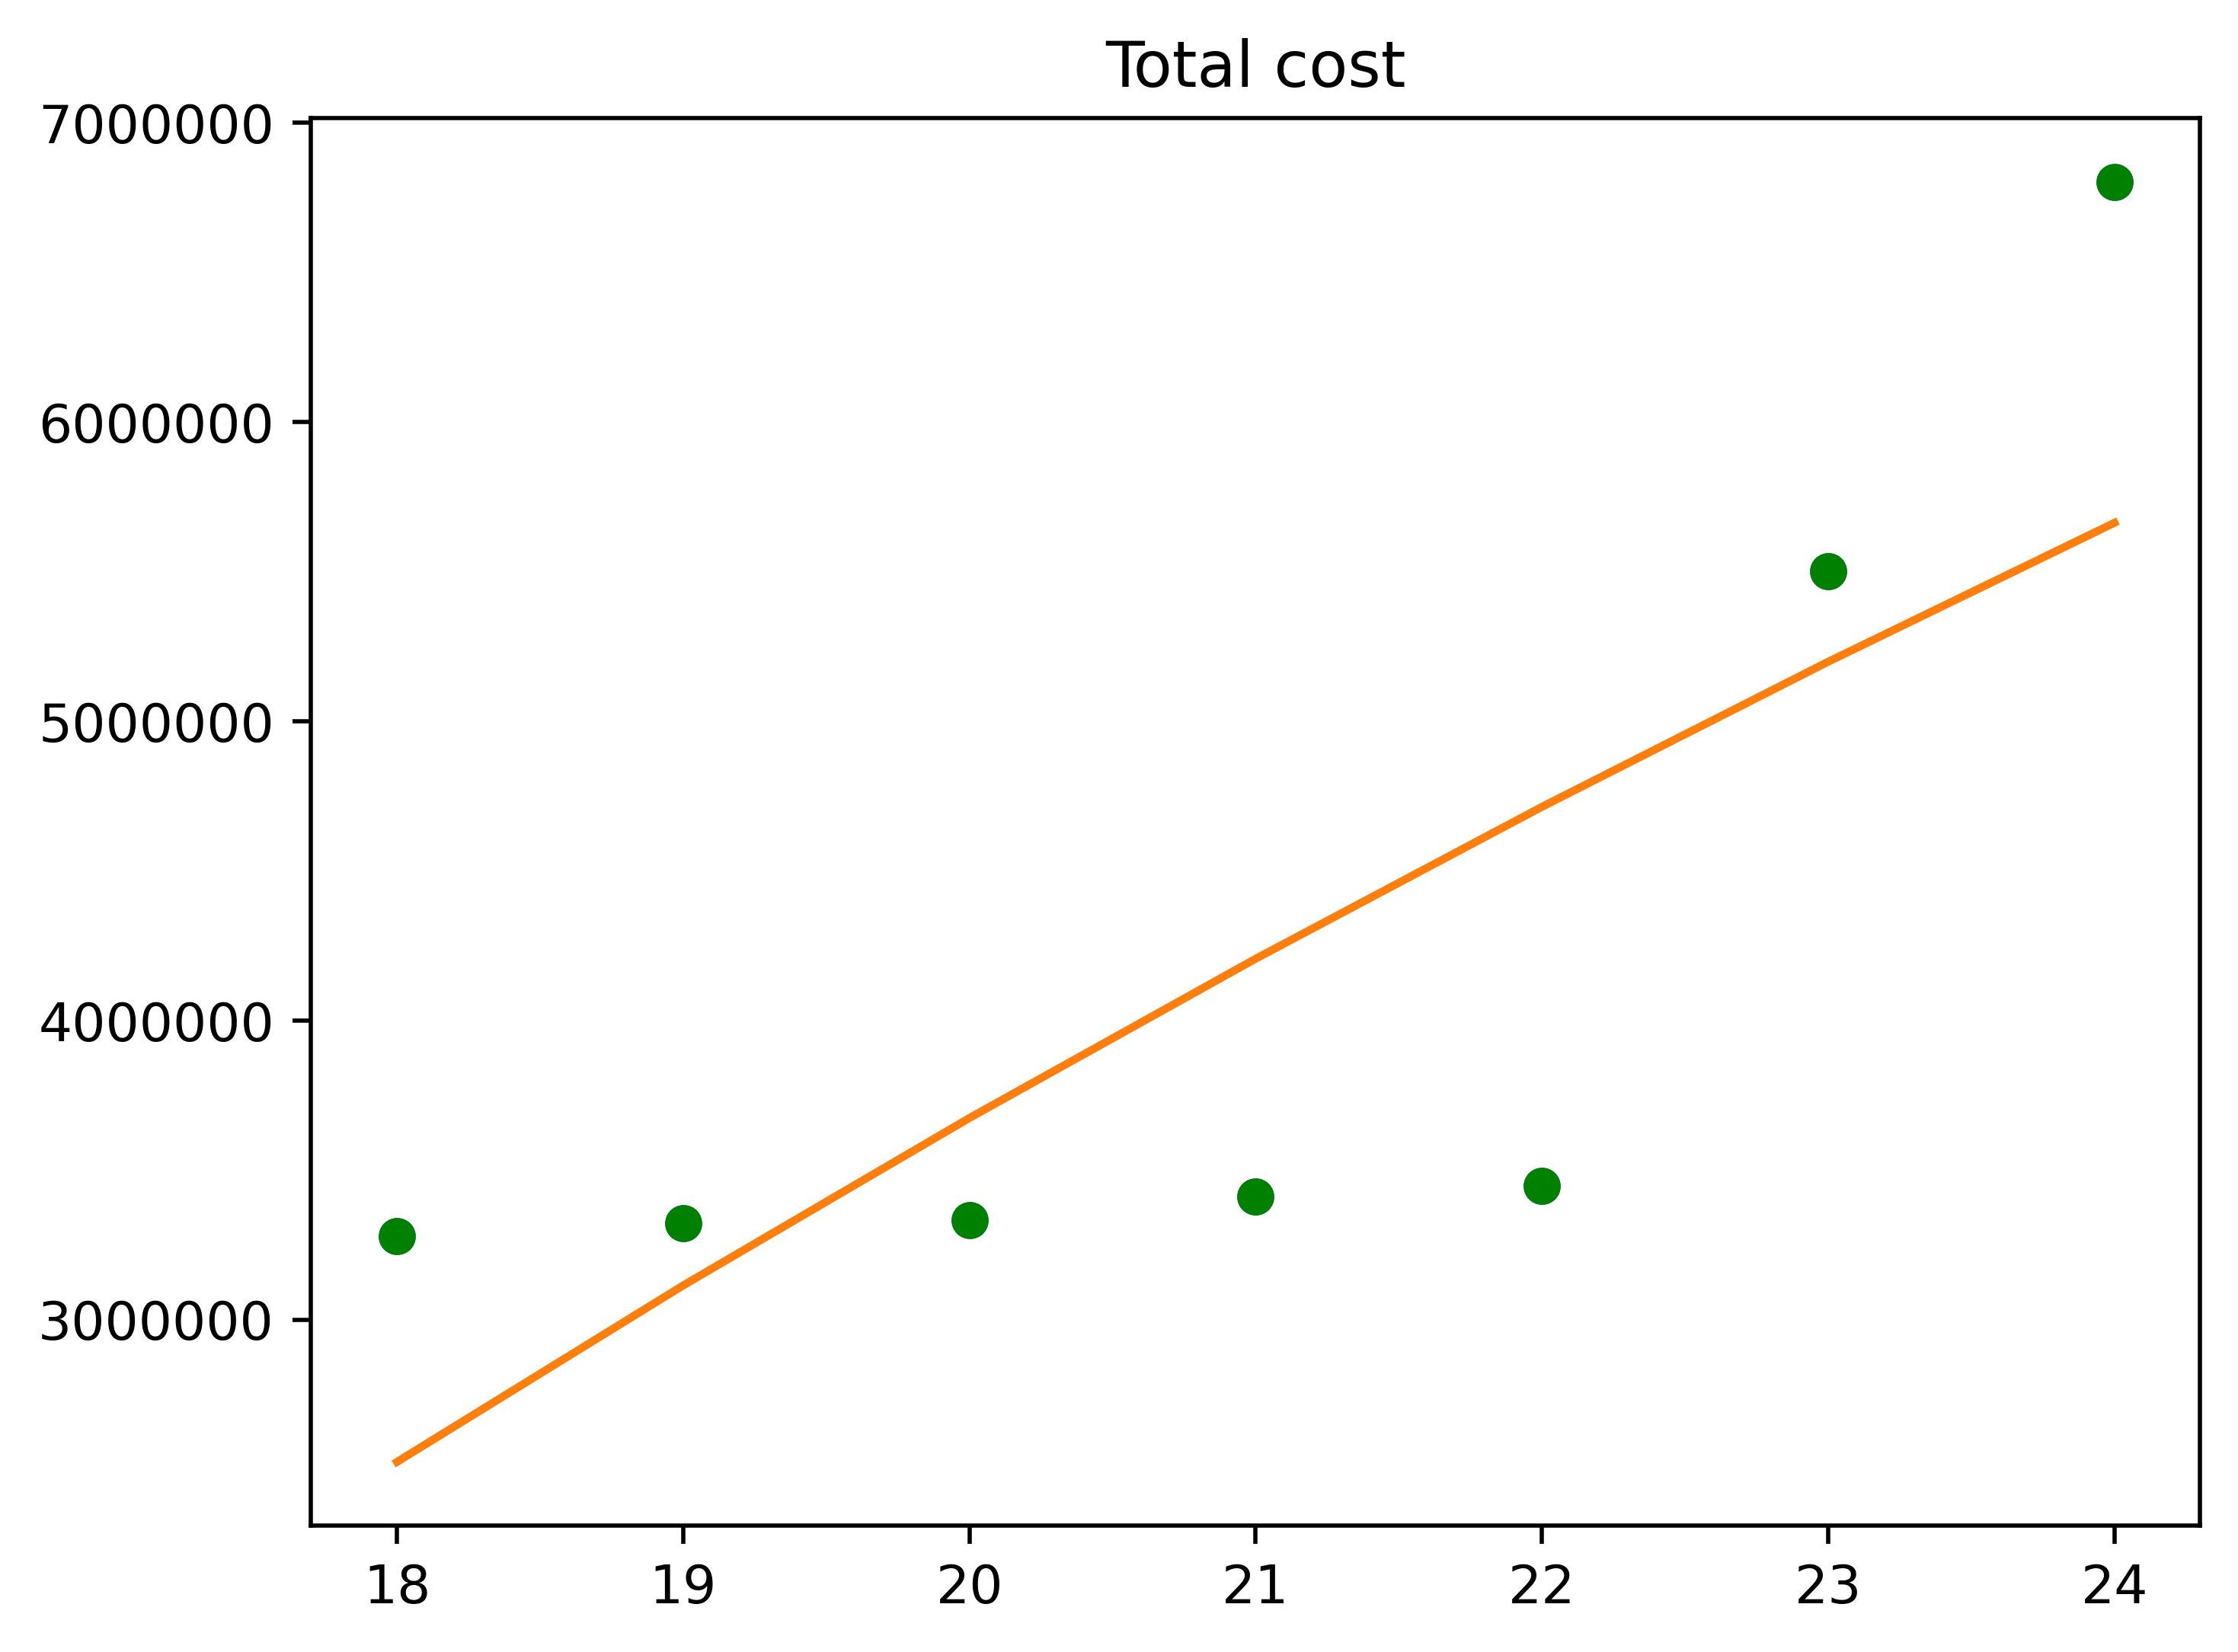

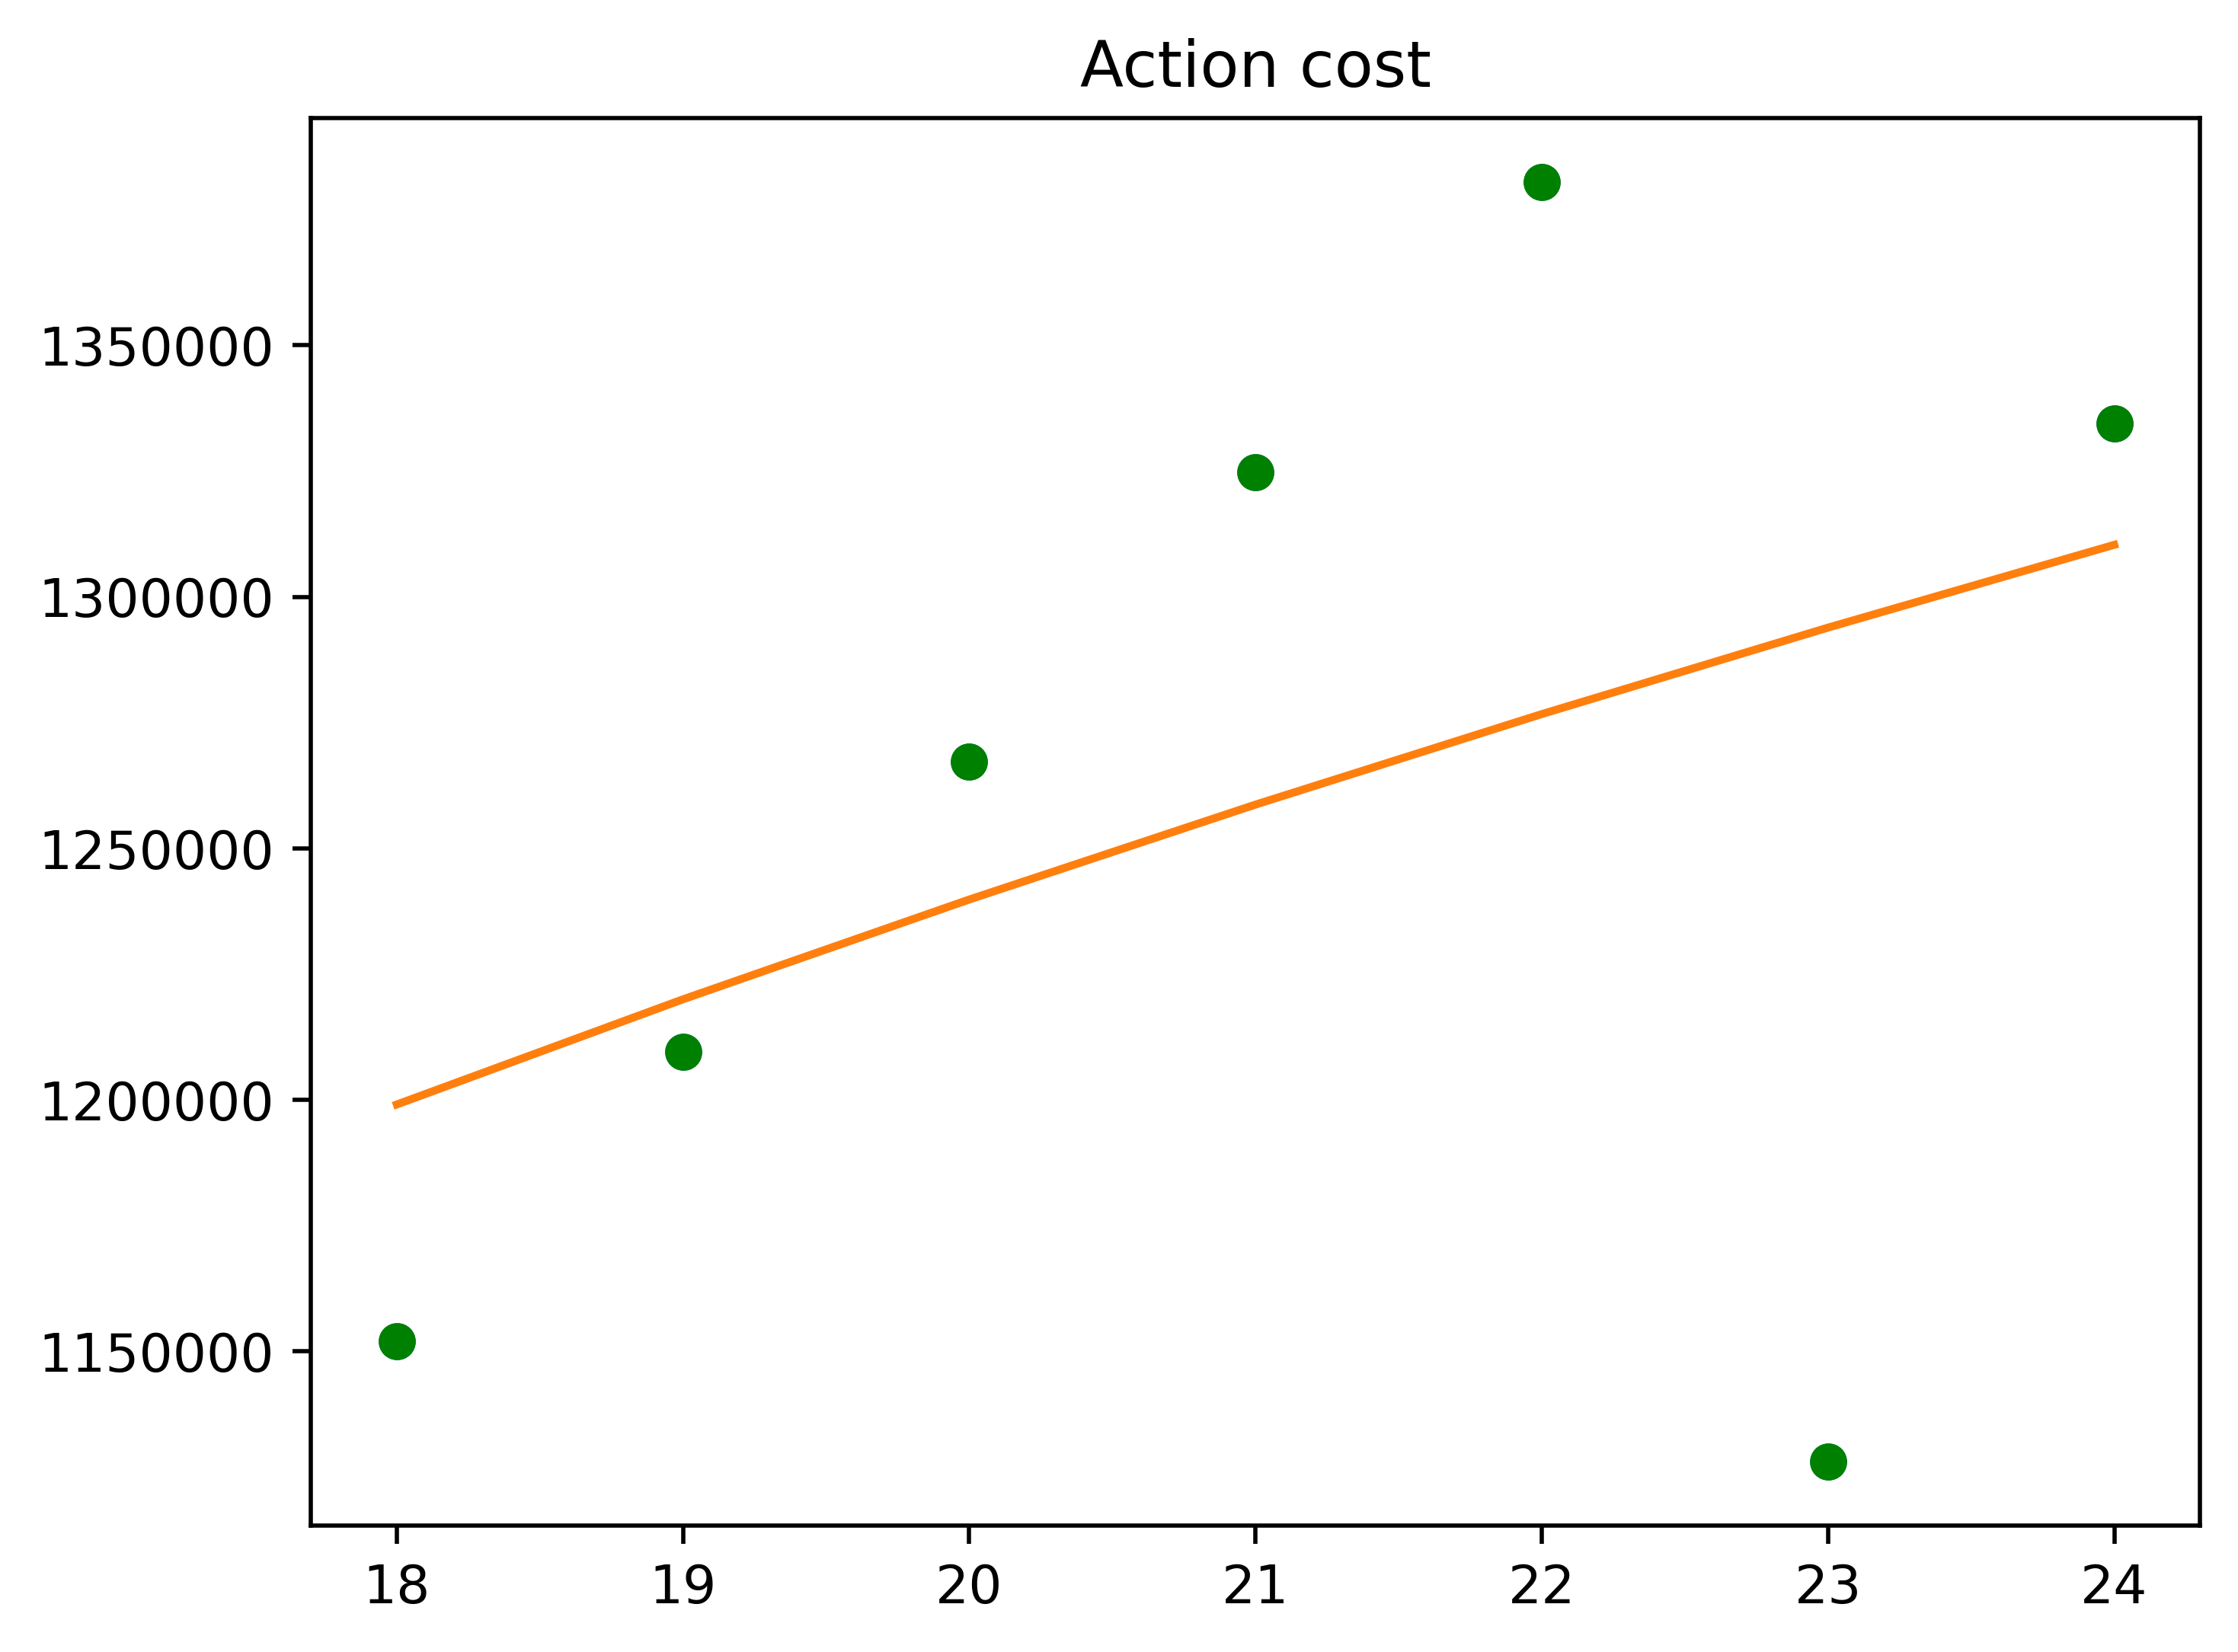

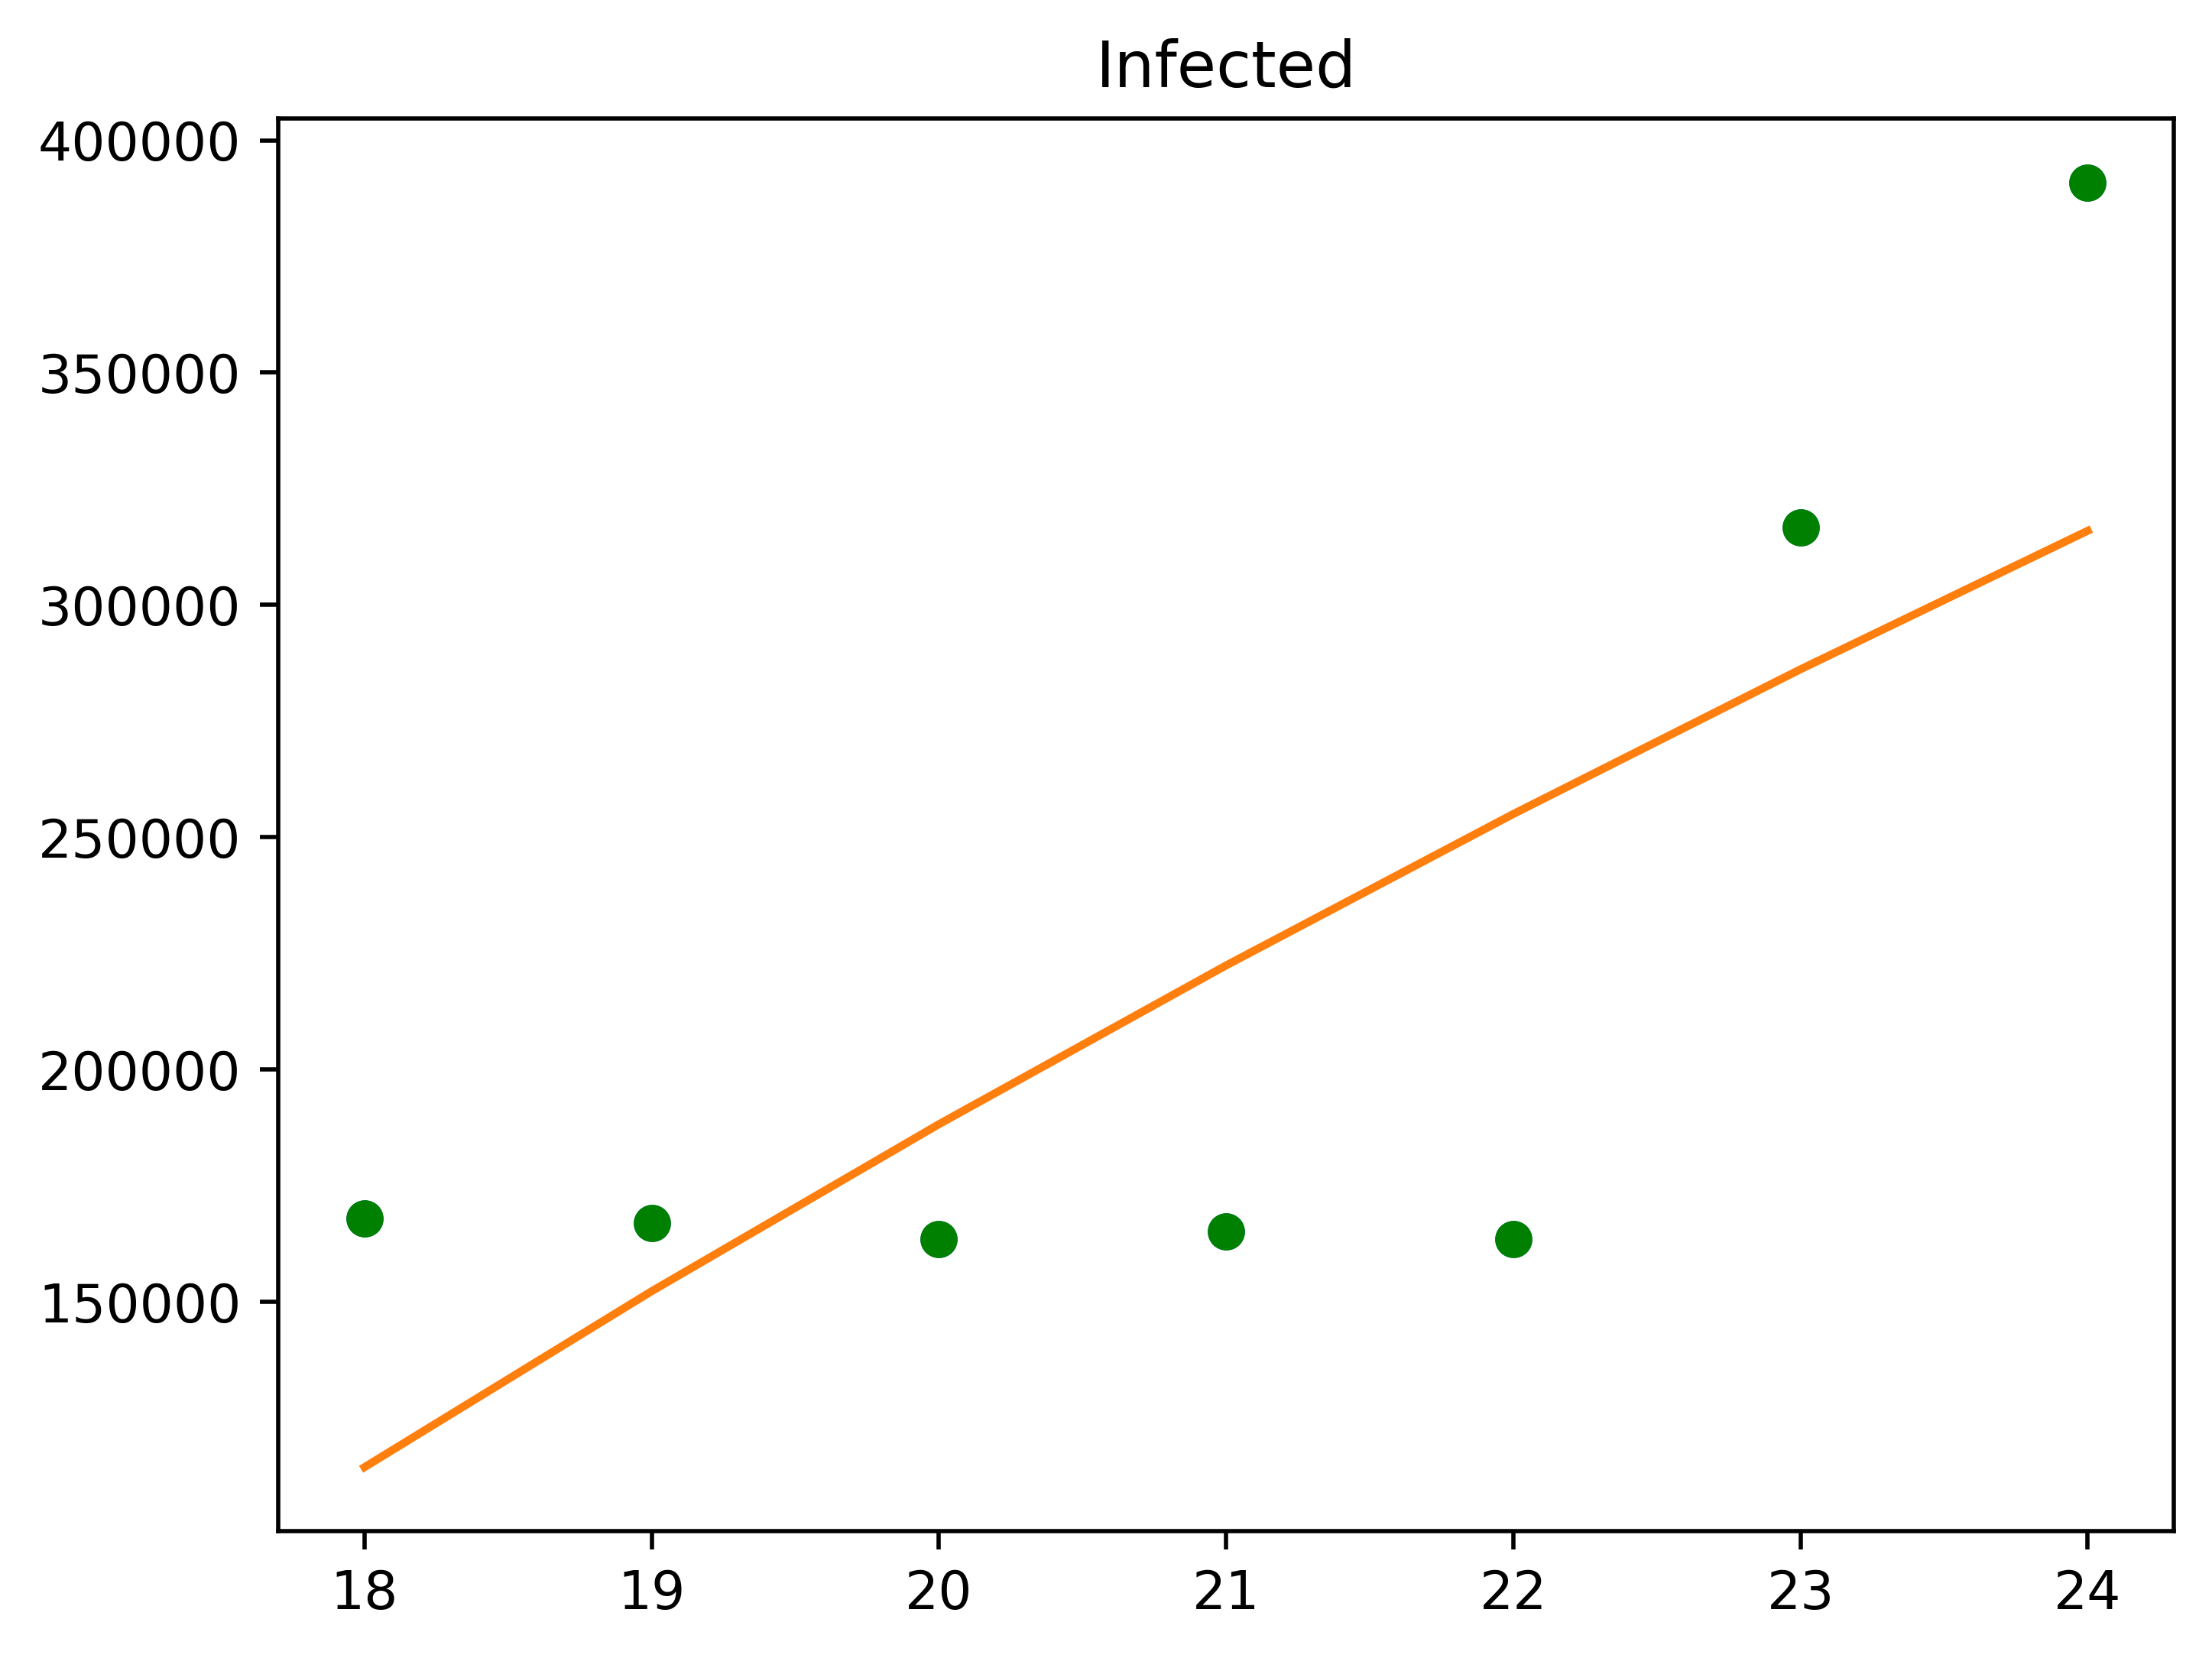

<Figure size 3200x2400 with 0 Axes>

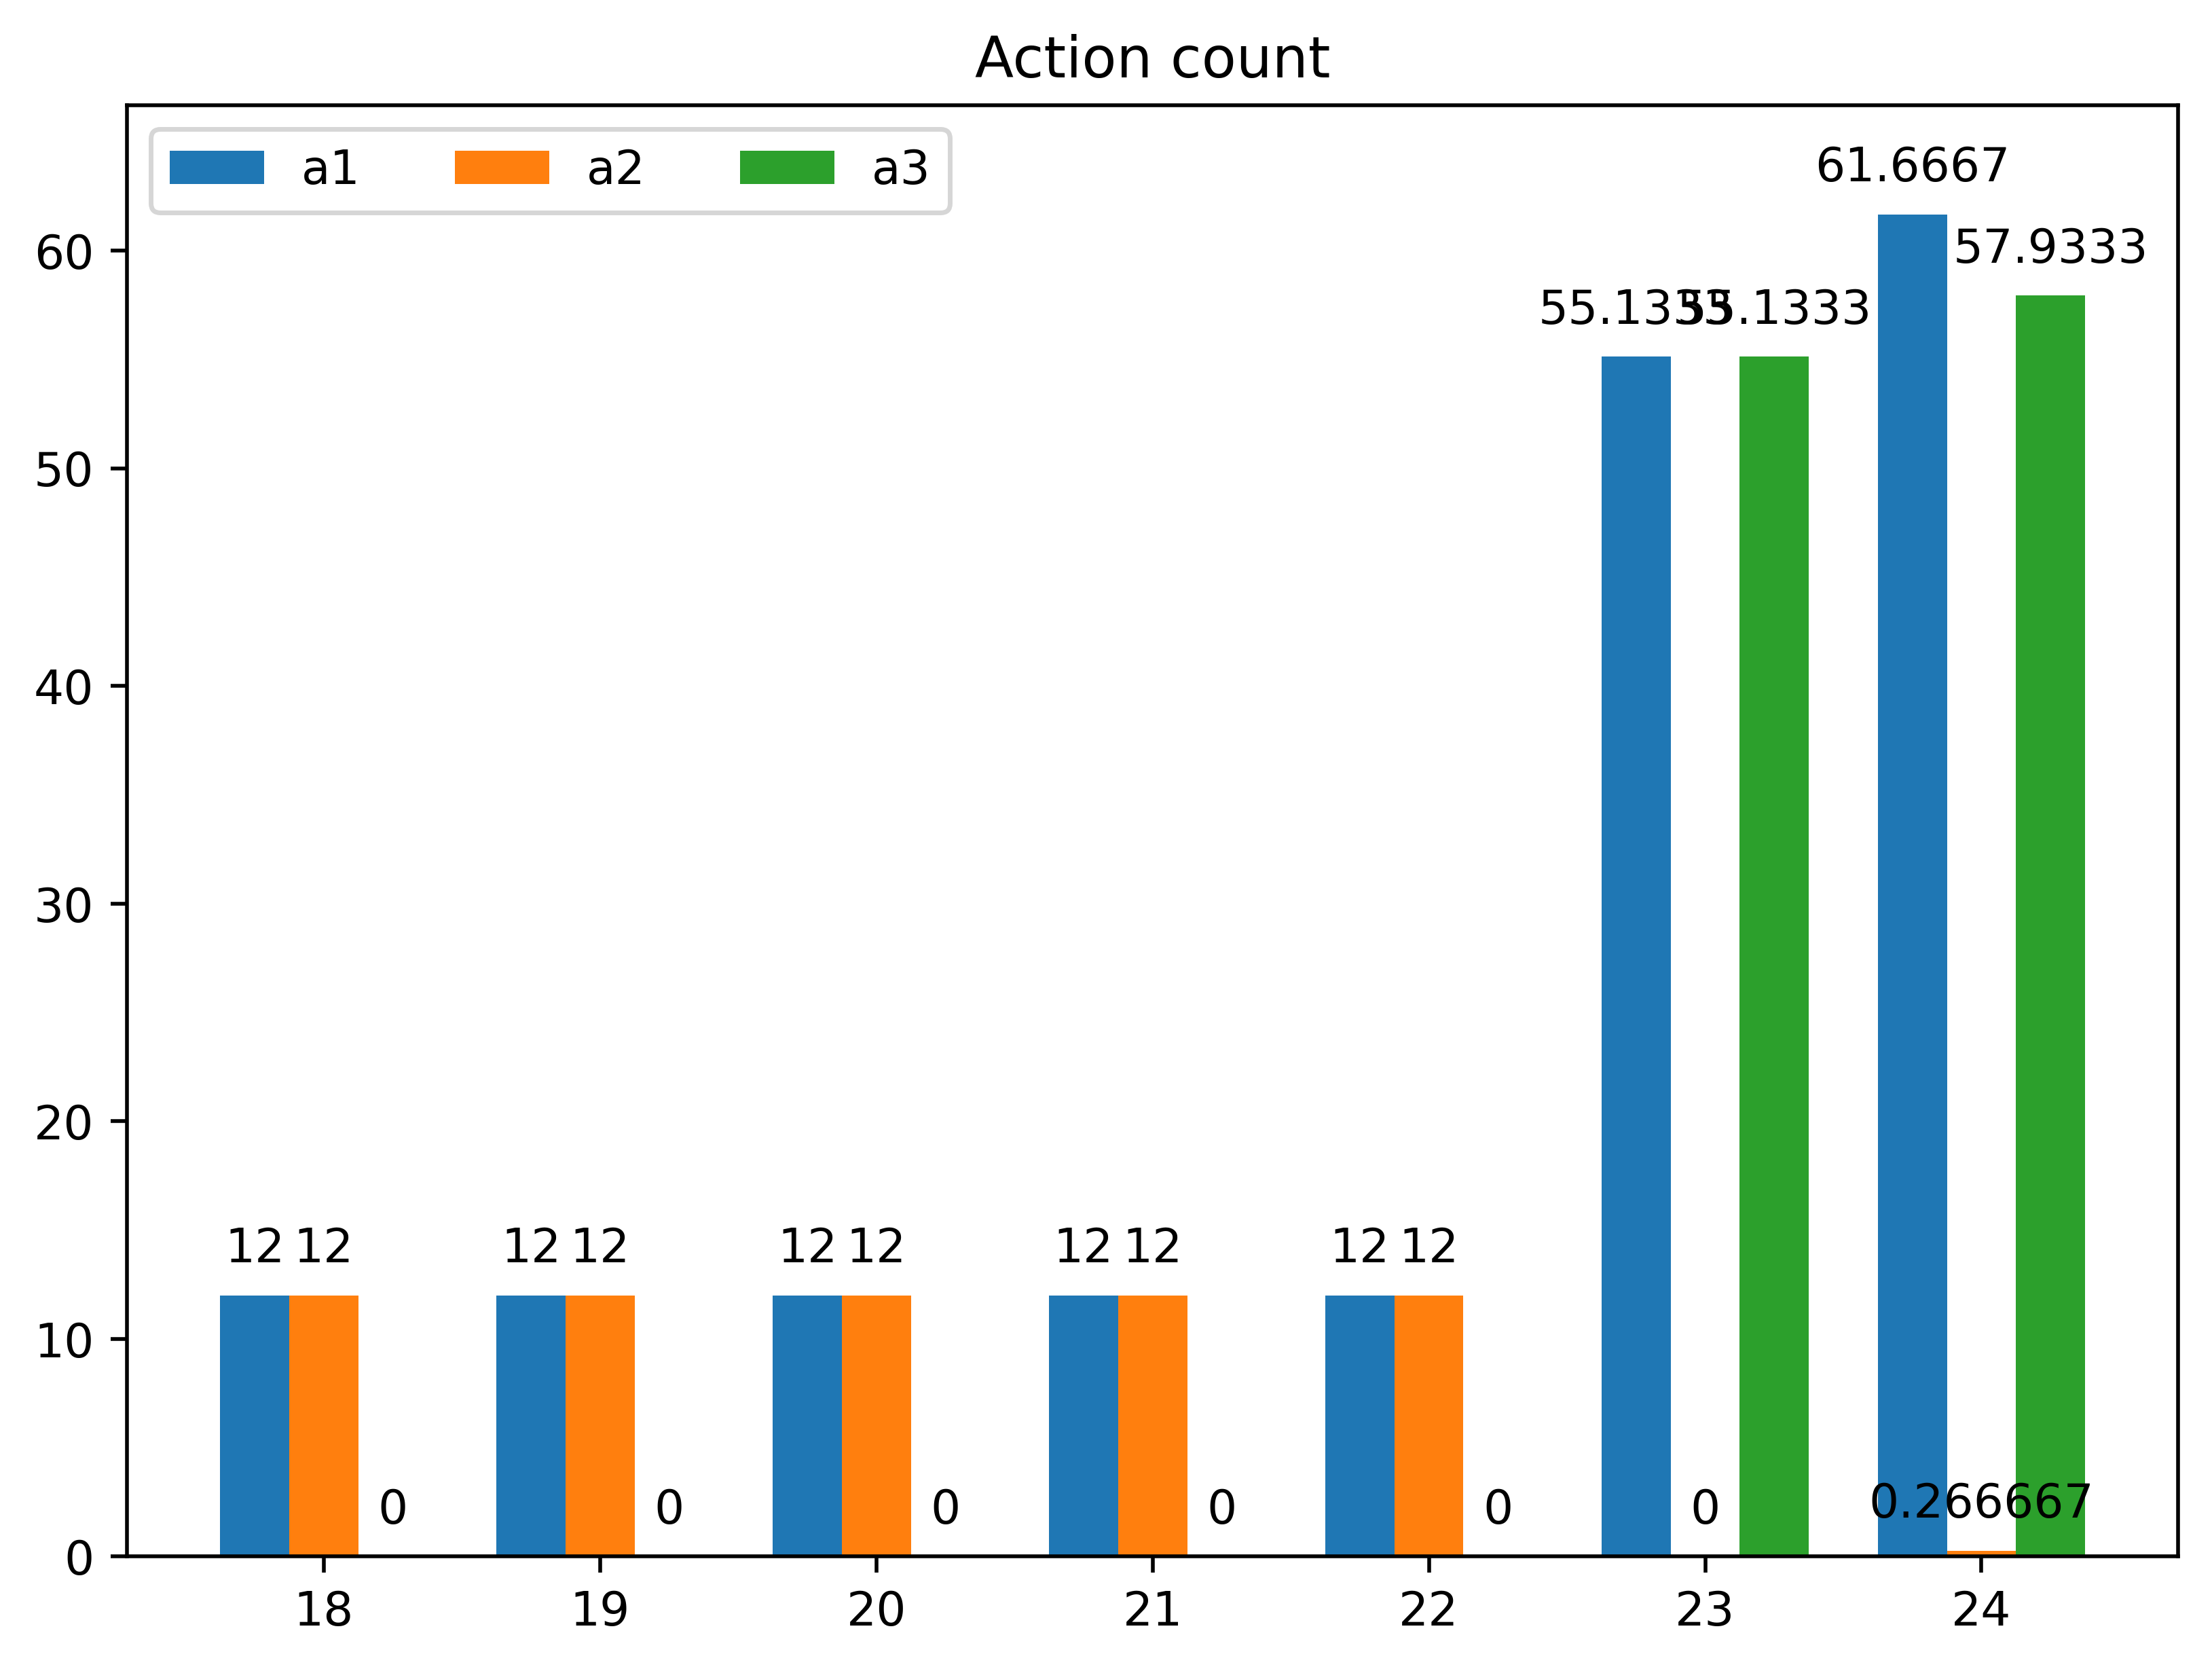

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
import pandas as pd
import scipy
from IPython.display import display, Markdown, Latex


parameter_analisys = 'a2_cost'

base_f = 'Analisi sensibilità/Analisi 1/Salvataggi/a2_cost/Con previsione res_type slope 2'
folders = os.listdir(base_f)

n_of_epoch = 11
total_epochs = 100

figure_dpi = 500
figure_dpi_bool = True



data, full_data = import_data(total_epochs, n_of_epoch, base_f, folders, parameter_analisys)

# Sorting
data.sort(key=lambda x: x['parameter_value'], reverse=False)


def plot_arr(arr_x, arr_y, title, errors=True):

    plt.ticklabel_format(style='plain', axis='y')
    if figure_dpi_bool: pyplot.rcParams['figure.dpi'] = figure_dpi
    plt.plot(arr_x, arr_y, 'o')

    unique_arr_x = np.unique(arr_x)
    unique_arr_dict = {}
    for x in unique_arr_x: unique_arr_dict[x] = []

    for i, y in enumerate(arr_y):
        unique_arr_dict[arr_x[i]].append(y)

    min_arr = []
    for k in unique_arr_dict.keys():
        min_arr.append(min(unique_arr_dict[k]))

    errors_x_arr = []
    errors_arr = []
    for k in unique_arr_dict.keys():
        mean = np.mean(unique_arr_dict[k])
        for el in unique_arr_dict[k]:
            if el > mean:
                errors_x_arr.append(k)
                errors_arr.append(el)   

    m, b = np.polyfit(arr_x, arr_y, 1)

    plt.plot(unique_arr_x, min_arr, 'o', label='Best', color='green')
    plt.title(title)
    if errors: plt.plot(errors_x_arr, errors_arr, 'o', label='Errors', color='red')

    if len(arr_x) > 1:
        s = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  arr_x    ,  arr_y)
        trend = [(s[0][0] + s[0][1] * np.log(x)) for x in arr_x]
        

        plt.plot(arr_x, trend, label='Total cost trend')
    
    plt.show()
    plt.clf()



def plot_strategy(arr_x, a1_cont, a2_cont, a3_cont):
    
    
    unique_arr_x = np.unique(arr_x)
    unique_arr_dict = {}
    overall_max = 0
    for x in unique_arr_x: unique_arr_dict[x] = {
        'a1': [],
        'a2': [],
        'a3': [],
    }

    plot_dict = {
        'a1': [],
        'a2': [],
        'a3': [],
    }
    for i, x in enumerate(arr_x):
        unique_arr_dict[x]['a1'].append(a1_cont[i])
        unique_arr_dict[x]['a2'].append(a2_cont[i])
        unique_arr_dict[x]['a3'].append(a3_cont[i])
        if a1_cont[i] > overall_max: overall_max = a1_cont[i]
        if a2_cont[i] > overall_max: overall_max = a2_cont[i]
        if a3_cont[i] > overall_max: overall_max = a3_cont[i]
        
    for k in unique_arr_dict.keys():
        plot_dict['a1'].append(np.mean(unique_arr_dict[k]['a1']))
        plot_dict['a2'].append(np.mean(unique_arr_dict[k]['a2']))
        plot_dict['a3'].append(np.mean(unique_arr_dict[k]['a3']))
        
    len_column = np.arange(len(unique_arr_x))
    
    width = 0.25
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    for k, m in plot_dict.items():
        offset = width * multiplier
        rects = ax.bar(len_column + offset, m, width, label=k)
        ax.bar_label(rects, padding=5)
        multiplier += 1
        
            
        
    
    ax.legend(loc='upper left', ncols=3)

    ax.set_title('Action count')
    ax.set_xticks(len_column + width, unique_arr_x)
    ax.set_ylim(0, overall_max + 5)
    plt.show()
    fig.clf()
    

arr_x = []
arr_t_cost= []
arr_a_cost = []
arr_infected = []
arr_a1 = []
arr_a2 = []
arr_a3 = []

for d in data:
    arr_x.append(d['parameter_value'])
    arr_t_cost.append(d['total_cost'])
    arr_a_cost.append(d['action_cost'])
    arr_infected.append(d['infected'])
    arr_a1.append(d['a1'])
    arr_a2.append(d['a2'])
    arr_a3.append(d['a3'])

if figure_dpi_bool: pyplot.rcParams['figure.dpi'] = figure_dpi



plot_arr(arr_x, arr_t_cost, 'Total cost')
plot_arr(arr_x, arr_a_cost, 'Action cost')
plot_arr(arr_x, arr_infected, 'Infected')



plot_strategy(arr_x, arr_a1, arr_a2, arr_a3)


def print_data_mk(full_data, parameter_value, last_n=0):
    
    for data in full_data:
        
        if data['parameter_value'] == parameter_value:
            print(f'Parameter value: {parameter_value}')

            data_to_use = {}
            for el in data['pd_csv_data'].keys():
                data_to_use[el] = data['pd_csv_data'][el]
            


            for el in data_to_use.keys():
                data_to_use[el] = data_to_use[el][1:]
            
            if last_n > 0:
                data_to_use_gen_length = len(data_to_use[list(data_to_use.keys())[0]])
                for el in data_to_use.keys():
                    data_to_use[el] = data_to_use[el][(data_to_use_gen_length - last_n):]

            data_table = pd.DataFrame(data=data_to_use, columns=data_to_use.keys())

            display(Markdown(data_table.to_markdown()))

# Seed: 2002, 2006
    




In [9]:
print_data_mk(full_data, 18, 40)
print_data_mk(full_data, 19, 40)

Parameter value: 18


|    |   Epoch |   Attendance |   Contagion |   Present contagion |   A1 |   A2 |   A3 |   Action on random |   Action on random zero |   Action on max |   Actions | A1 cost           | A2 cost           |   A3 cost | Action cost       |   New infections |   New infected cost | Total cost   |   Total revenues | Epoch txt   |
|---:|--------:|-------------:|------------:|--------------------:|-----:|-----:|-----:|-------------------:|------------------------:|----------------:|----------:|:------------------|:------------------|----------:|:------------------|-----------------:|--------------------:|:-------------|-----------------:|:------------|
|  0 |      61 |        64537 |       13705 |                3383 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1155 |              173250 | 269250,0     |                0 | -           |
|  1 |      62 |        64586 |       12616 |                3218 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1056 |              158400 | 254400,0     |                0 | -           |
|  2 |      63 |        64704 |       12902 |                3150 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1082 |              162300 | 258300,0     |                0 | -           |
|  3 |      64 |        64812 |       15355 |                3859 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1305 |              195750 | 291750,0     |                0 | -           |
|  4 |      65 |        64799 |       13540 |                3240 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1140 |              171000 | 267000,0     |                0 | -           |
|  5 |      66 |        64683 |       12396 |                3106 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1036 |              155400 | 251400,0     |                0 | -           |
|  6 |      67 |        64837 |       14783 |                3748 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1253 |              187950 | 283950,0     |                0 | -           |
|  7 |      68 |        64467 |       12902 |                3132 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1082 |              162300 | 258300,0     |                0 | -           |
|  8 |      69 |        64365 |       14068 |                3616 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1188 |              178200 | 274200,0     |                0 | -           |
|  9 |      70 |        64706 |       13452 |                3454 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1132 |              169800 | 265800,0     |                0 | -           |
| 10 |      71 |        64275 |       14112 |                3400 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1192 |              178800 | 274800,0     |                0 | -           |
| 11 |      72 |        64787 |       13947 |                3566 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1177 |              176550 | 272550,0     |                0 | -           |
| 12 |      73 |        64766 |       13529 |                3459 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1139 |              170850 | 266850,0     |                0 | -           |
| 13 |      74 |        64429 |       13991 |                3441 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1181 |              177150 | 273150,0     |                0 | -           |
| 14 |      75 |        64640 |       13980 |                3479 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1180 |              177000 | 273000,0     |                0 | -           |
| 15 |      76 |        64597 |       13419 |                3308 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1129 |              169350 | 265350,0     |                0 | -           |
| 16 |      77 |        64629 |       13727 |                3354 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1157 |              173550 | 269550,0     |                0 | -           |
| 17 |      78 |        64301 |       13298 |                3198 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1118 |              167700 | 263700,0     |                0 | -           |
| 18 |      79 |        64661 |       13617 |                3413 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1147 |              172050 | 268050,0     |                0 | -           |
| 19 |      80 |        64422 |       13397 |                3304 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1127 |              169050 | 265050,0     |                0 | -           |
| 20 |      81 |        64493 |       13639 |                3399 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1149 |              172350 | 268350,0     |                0 | -           |
| 21 |      82 |        64616 |       13309 |                3285 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1119 |              167850 | 263850,0     |                0 | -           |
| 22 |      83 |        64583 |       12385 |                3092 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1035 |              155250 | 251250,0     |                0 | -           |
| 23 |      84 |        65055 |       14431 |                3603 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1221 |              183150 | 279150,0     |                0 | -           |
| 24 |      85 |        64566 |       14398 |                3593 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1218 |              182700 | 278700,0     |                0 | -           |
| 25 |      86 |        64522 |       13199 |                3169 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1109 |              166350 | 262350,0     |                0 | -           |
| 26 |      87 |        64743 |       13408 |                3443 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1128 |              169200 | 265200,0     |                0 | -           |
| 27 |      88 |        64836 |       14288 |                3583 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1208 |              181200 | 277200,0     |                0 | -           |
| 28 |      89 |        64680 |       13914 |                3372 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1174 |              176100 | 272100,0     |                0 | -           |
| 29 |      90 |        64600 |       13276 |                3339 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1116 |              167400 | 263400,0     |                0 | -           |
| 30 |      91 |        64719 |       14684 |                3649 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1244 |              186600 | 282600,0     |                0 | -           |
| 31 |      92 |        65028 |       13760 |                3460 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1160 |              174000 | 270000,0     |                0 | -           |
| 32 |      93 |        64683 |       14563 |                3637 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1233 |              184950 | 280950,0     |                0 | -           |
| 33 |      94 |        64664 |       13760 |                3513 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1160 |              174000 | 270000,0     |                0 | -           |
| 34 |      95 |        64517 |       14882 |                3616 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1262 |              189300 | 285300,0     |                0 | -           |
| 35 |      96 |        64674 |       14574 |                3584 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1234 |              185100 | 281100,0     |                0 | -           |
| 36 |      97 |        64658 |       13683 |                3366 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1153 |              172950 | 268950,0     |                0 | -           |
| 37 |      98 |        64835 |       14002 |                3342 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1182 |              177300 | 273300,0     |                0 | -           |
| 38 |      99 |        64569 |       13232 |                3364 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1112 |              166800 | 262800,0     |                0 | -           |
| 39 |     100 |        64579 |       13705 |                3315 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 86399,99999999999 |         0 | 95999,99999999999 |             1155 |              173250 | 269250,0     |                0 | -           |

Parameter value: 19


|    |   Epoch |   Attendance |   Contagion |   Present contagion |   A1 |   A2 |   A3 |   Action on random |   Action on random zero |   Action on max |   Actions | A1 cost           | A2 cost           |   A3 cost | Action cost        |   New infections |   New infected cost | Total cost   |   Total revenues | Epoch txt   |
|---:|--------:|-------------:|------------:|--------------------:|-----:|-----:|-----:|-------------------:|------------------------:|----------------:|----------:|:------------------|:------------------|----------:|:-------------------|-----------------:|--------------------:|:-------------|-----------------:|:------------|
|  0 |      61 |        64742 |       12781 |                3196 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1071 |              160650 | 261450,0     |                0 | -           |
|  1 |      62 |        64557 |       13793 |                3396 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1163 |              174450 | 275250,0     |                0 | -           |
|  2 |      63 |        64242 |       12682 |                3138 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1062 |              159300 | 260100,0     |                0 | -           |
|  3 |      64 |        64627 |       15608 |                3925 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1328 |              199200 | 300000,0     |                0 | -           |
|  4 |      65 |        64886 |       12814 |                3160 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1074 |              161100 | 261900,0     |                0 | -           |
|  5 |      66 |        64699 |       12638 |                3112 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1058 |              158700 | 259500,0     |                0 | -           |
|  6 |      67 |        64402 |       14332 |                3503 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1212 |              181800 | 282600,0     |                0 | -           |
|  7 |      68 |        64953 |       13595 |                3329 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1145 |              171750 | 272550,0     |                0 | -           |
|  8 |      69 |        64758 |       13221 |                3245 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1111 |              166650 | 267450,0     |                0 | -           |
|  9 |      70 |        65072 |       14761 |                3740 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1251 |              187650 | 288450,0     |                0 | -           |
| 10 |      71 |        64986 |       13837 |                3487 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1167 |              175050 | 275850,0     |                0 | -           |
| 11 |      72 |        64808 |       14090 |                3457 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1190 |              178500 | 279300,0     |                0 | -           |
| 12 |      73 |        64690 |       12220 |                2879 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1020 |              153000 | 253800,0     |                0 | -           |
| 13 |      74 |        64413 |       12935 |                3199 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1085 |              162750 | 263550,0     |                0 | -           |
| 14 |      75 |        65356 |       13595 |                3350 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1145 |              171750 | 272550,0     |                0 | -           |
| 15 |      76 |        64503 |       13870 |                3358 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1170 |              175500 | 276300,0     |                0 | -           |
| 16 |      77 |        64984 |       14200 |                3458 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1200 |              180000 | 280800,0     |                0 | -           |
| 17 |      78 |        64968 |       12869 |                3220 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1079 |              161850 | 262650,0     |                0 | -           |
| 18 |      79 |        64712 |       13738 |                3334 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1158 |              173700 | 274500,0     |                0 | -           |
| 19 |      80 |        65091 |       13397 |                3245 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1127 |              169050 | 269850,0     |                0 | -           |
| 20 |      81 |        64599 |       13364 |                3238 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1124 |              168600 | 269400,0     |                0 | -           |
| 21 |      82 |        65102 |       12682 |                3191 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1062 |              159300 | 260100,0     |                0 | -           |
| 22 |      83 |        64928 |       13859 |                3413 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1169 |              175350 | 276150,0     |                0 | -           |
| 23 |      84 |        64857 |       14376 |                3614 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1216 |              182400 | 283200,0     |                0 | -           |
| 24 |      85 |        64589 |       13166 |                3169 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1106 |              165900 | 266700,0     |                0 | -           |
| 25 |      86 |        65294 |       13243 |                3172 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1113 |              166950 | 267750,0     |                0 | -           |
| 26 |      87 |        64898 |       14090 |                3445 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1190 |              178500 | 279300,0     |                0 | -           |
| 27 |      88 |        64658 |       14464 |                3621 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1224 |              183600 | 284400,0     |                0 | -           |
| 28 |      89 |        64624 |       13980 |                3467 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1180 |              177000 | 277800,0     |                0 | -           |
| 29 |      90 |        64521 |       13991 |                3435 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1181 |              177150 | 277950,0     |                0 | -           |
| 30 |      91 |        64983 |       14453 |                3595 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1223 |              183450 | 284250,0     |                0 | -           |
| 31 |      92 |        64804 |       14574 |                3471 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1234 |              185100 | 285900,0     |                0 | -           |
| 32 |      93 |        64556 |       14816 |                3653 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1256 |              188400 | 289200,0     |                0 | -           |
| 33 |      94 |        64915 |       13661 |                3469 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1151 |              172650 | 273450,0     |                0 | -           |
| 34 |      95 |        64219 |       12968 |                3215 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1088 |              163200 | 264000,0     |                0 | -           |
| 35 |      96 |        64904 |       13848 |                3418 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1168 |              175200 | 276000,0     |                0 | -           |
| 36 |      97 |        64514 |       13232 |                3154 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1112 |              166800 | 267600,0     |                0 | -           |
| 37 |      98 |        64644 |       13683 |                3307 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1153 |              172950 | 273750,0     |                0 | -           |
| 38 |      99 |        64442 |       13881 |                3491 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1171 |              175650 | 276450,0     |                0 | -           |
| 39 |     100 |        64527 |       13848 |                3453 |   15 |   15 |    0 |                  0 |                       0 |               1 |         1 | 9599,999999999998 | 91199,99999999999 |         0 | 100799,99999999999 |             1168 |              175200 | 276000,0     |                0 | -           |